# REDSoX polarimeter effective area and figure of merit

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [37]:
import os
import sys
from glob import glob
import copy

import numpy as np

import astropy
import astropy.coordinates
from astropy.table import Table
import astropy.units as u

# REDSoX code is not installed, but just sits in a local directory
sys.path.append('../redsox')
from mirror import Ageom
from run_settings import wave
#import redsox

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
from astropy.visualization import astropy_mpl_style
# plt.style.use(astropy_mpl_style)
%matplotlib inline

In [4]:
datadir = '/melkor/d1/guenther/projects/REDSoX/sims/'
figureout = '/melkor/d1/guenther/Dropbox/REDSoX File Transfers/raytrace/plots/'

In [5]:
point_fixed = Table.read(os.path.join(datadir, 'aeff', 'pointing_fixed.fits'))
sk = astropy.coordinates.SkyCoord.guess_from_table(point_fixed, unit='deg')
point_fixed['separation'] = sk.separation(astropy.coordinates.SkyCoord(30., 30., unit='deg')).arcsec
point_fixed.sort('separation')

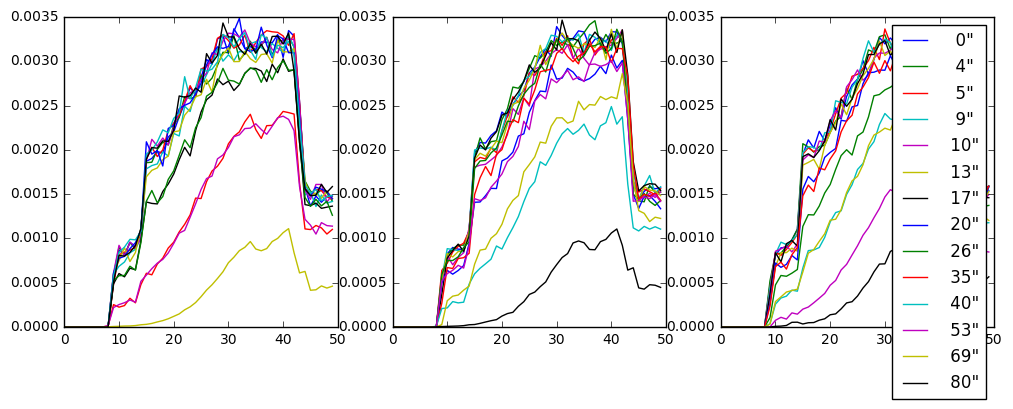

In [6]:
fig = plt.figure(figsize=(12, 4))
for j in [1,2,3]:
    ax = fig.add_subplot(1, 3, j)
    for i in range(len(point_fixed)):
        ax.plot(point_fixed[i]['Aeff'][:, j], label='{0:3.0f}"'.format(point_fixed['separation'][i]))
ax.legend()

(0.8, 1)

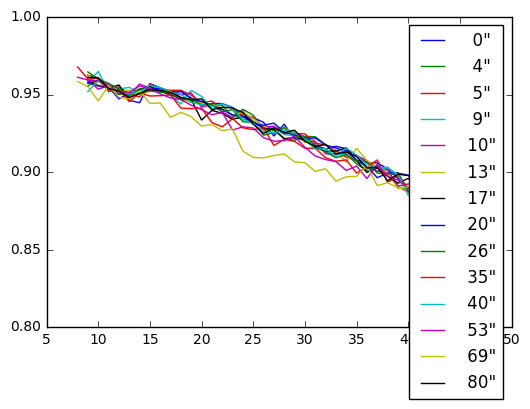

In [7]:
for i in range(len(point_fixed)):
    plt.plot(-point_fixed[i]['modulation'][:, 1], label='{0:3.0f}"'.format(point_fixed['separation'][i]))
plt.legend()
plt.ylim([0.8, 1])

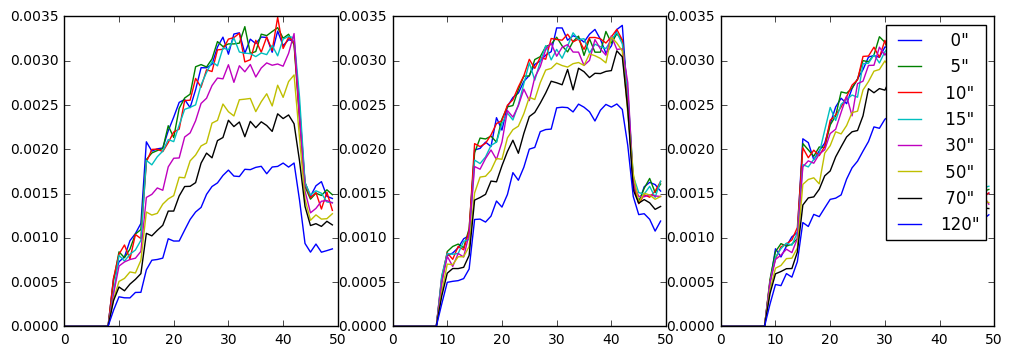

In [49]:
point_jitter = Table.read(os.path.join(datadir, 'aeff', 'pointing_jitter.fits'))

fig = plt.figure(figsize=(12, 4))
for j in [1,2,3]:
    ax = fig.add_subplot(1, 3, j)
    for i in range(len(point_jitter)):
        ax.plot(point_jitter[i]['Aeff'][:, j], label='{0:3.0f}"'.format(point_jitter['jitter'][i]))
ax.legend()


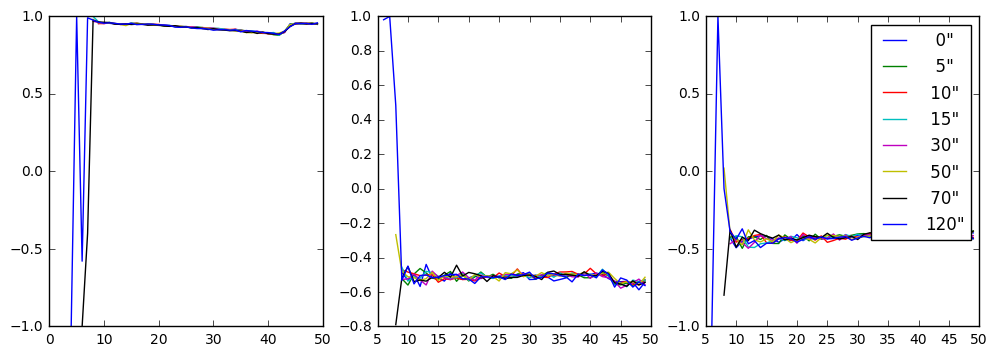

In [10]:
fig = plt.figure(figsize=(12, 4))
for j in [1,2,3]:
    ax = fig.add_subplot(1, 3, j)
    for i in range(len(point_jitter)):
        ax.plot(-point_jitter[i]['modulation'][:, j], label='{0:3.0f}"'.format(point_jitter['jitter'][i]))
ax.legend()

In [11]:
scatter = Table.read(os.path.join(datadir, 'aeff', 'mirrorscatter.fits'))

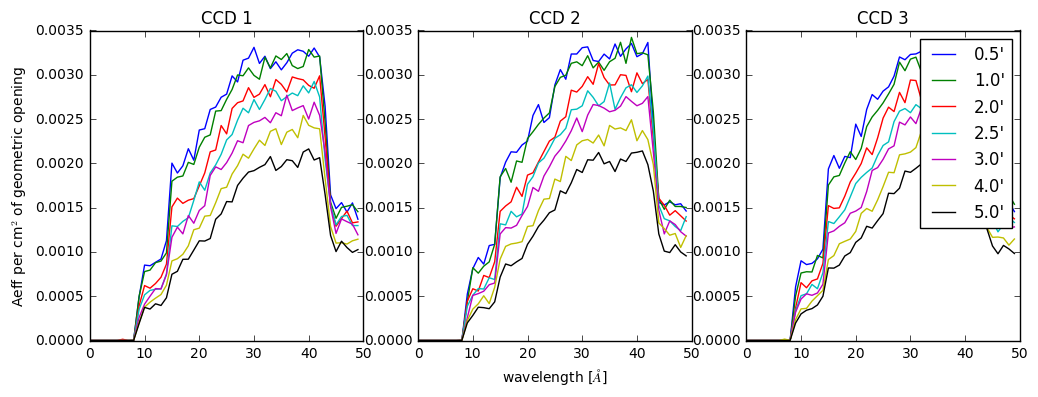

In [12]:
fig = plt.figure(figsize=(12, 4))
for j in [1,2,3]:
    ax = fig.add_subplot(1, 3, j)
    ax.set_title('CCD {0}'.format(j))
    for i in range(len(scatter)):
        ax.plot(scatter[i]['Aeff'][:, j], label="{0:3.1f}'".format(np.rad2deg(scatter['inplane'][i]) * 60*2.35))
ax.legend()
fig.axes[0].set_ylabel('Aeff per cm$^2$ of geometric opening')
fig.axes[1].set_xlabel('wavelength [$\AA$]')
fig.savefig(figureout + 'sizePSF.pdf')

(0.8, 1)

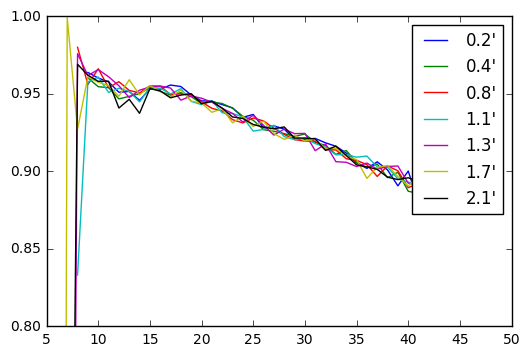

In [13]:
for i in range(len(scatter)):
    plt.plot(-scatter[i]['modulation'][:, 1],  label="{0:3.1f}'".format(np.rad2deg(scatter['inplane'][i]) * 60))
plt.legend()
plt.ylim([0.8, 1])

## Plots for the proposal

In [14]:
phot = Table.read(datadir + 'photons_spectrum.fits')
phot['wave'] = (phot['energy']).to(u.Angstrom, equivalencies=u.spectral())
# Draw from the distribution
phot = phot[phot['probability'] > np.random.uniform(size=len(phot))]

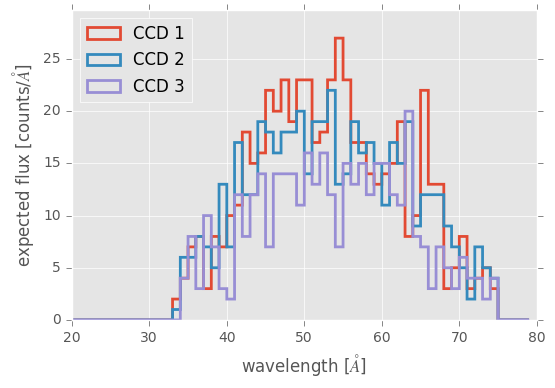

In [16]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    outmax = 0
    for i in [1, 2, 3]:
        ind = (phot['CCD_ID'] == i)
        out = ax.hist(phot['wave'][ind], histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(20, 80), label='CCD {0}'.format(i), lw=2)
        outmax = np.max([outmax, np.max(out[0])])

    ax.set_ylim(0, outmax*1.1)
    ax.legend(loc='upper left')
    ax.set_xlabel('wavelength [$\AA$]')
    ax.set_ylabel('expected flux [counts/$\AA$]')
    fig.savefig(figureout + 'obsspec.pdf')

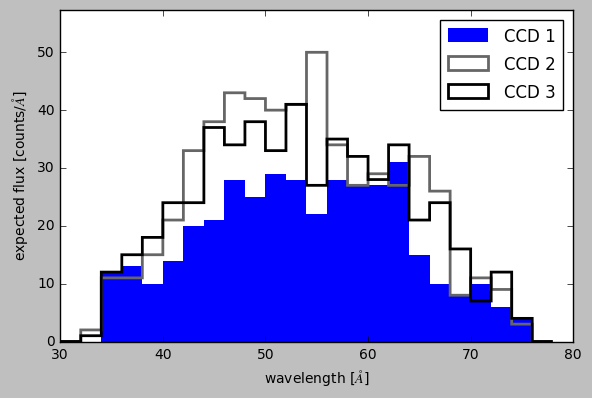

In [85]:
with plt.style.context('default'):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    outmax = 0
    
    ind = (phot['CCD_ID'] == 3)
    out = ax.hist(phot['wave'][ind], #histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 1', lw=0)#, fc='y')
    ind = (phot['CCD_ID'] == 1)
    out = ax.hist(phot['wave'][ind], histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 2', lw=2, ec='0.4')
    ind = (phot['CCD_ID'] == 2)
    out = ax.hist(phot['wave'][ind], histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 3', lw=2, ec='k')
    outmax = np.max([outmax, np.max(out[0])])

    ax.set_ylim(0, outmax*1.4)
    ax.legend(loc='upper right')
    ax.set_xlabel('wavelength [$\AA$]')
    ax.set_ylabel('expected flux [counts/$\AA$]')
    fig.subplots_adjust(bottom=.15, right=0.98, top=.98)
    fig.savefig(figureout + 'obsspec.pdf')

In [17]:
photdraw = phot[phot['probability'] > np.random.uniform(size=len(phot))]

/nfs/melkor/d1/guenther/soft/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


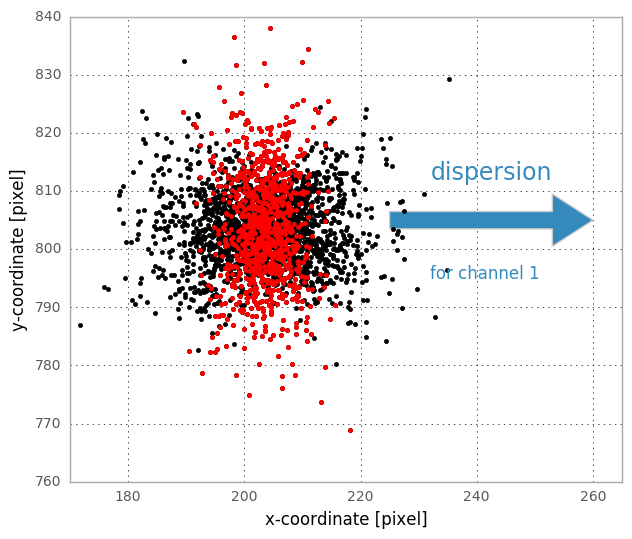

In [26]:
with plt.style.context(astropy_mpl_style):
    fig = plt.figure()
    ax2 = fig.add_subplot(111, aspect='equal')
    ind = photdraw['CCD_ID'] == 0
    ax2.plot(photdraw['detpix_x'][ind], photdraw['detpix_y'][ind], 'k.', label='all photons')
    ind1 = photdraw['grating_id'] < 2000
    ax2.plot(photdraw['detpix_x'][ind & ind1], photdraw['detpix_y'][ind & ind1], 'r.', label='channel 1')
    arrow = Arrow(225, 805, 35, 0, width=15.)
    ax2.add_patch(arrow)
    ax2.text(232, 812., 'dispersion', color=arrow.get_fc(), fontsize=17)
    ax2.text(232, 795., 'for channel 1', color=arrow.get_fc(), fontsize=12)
    ax2.set_xlabel('x-coordinate [pixel]')
    ax2.set_ylabel('y-coordinate [pixel]')
    ax2.set_xlim(170, 265)
    #ax2.legend()
    fig.savefig(figureout + 'CCD0_image.pdf')

/nfs/melkor/d1/guenther/soft/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


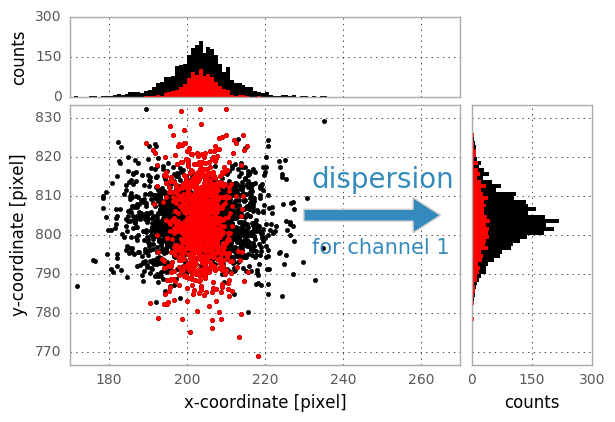

In [32]:
from matplotlib.ticker import NullFormatter, MaxNLocator

nullfmt = NullFormatter()         # no labels
max3loc = MaxNLocator(2)
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

with plt.style.context(astropy_mpl_style):
    # start with a rectangular Figure
    plt.figure(1, figsize=(6, 4))

    axScatter = plt.axes(rect_scatter, aspect='equal')
    axHistx = plt.axes(rect_histx, sharex=axScatter)
    axHisty = plt.axes(rect_histy, sharey=axScatter)

    # no labels
    #axHistx.xaxis.set_major_formatter(nullfmt)
    #axHisty.yaxis.set_major_formatter(nullfmt)
    xticklabels = axHistx.get_xticklabels() + axHisty.get_yticklabels()
    plt.setp(xticklabels, visible=False)
    
    axHistx.yaxis.set_major_locator(max3loc)
    axHisty.xaxis.set_major_locator(max3loc)
    # the scatter plot:
    ind = photdraw['CCD_ID'] == 0
    axScatter.plot(photdraw['detpix_x'][ind], photdraw['detpix_y'][ind], 'k.', label='all photons')
    ind1 = photdraw['grating_id'] < 2000
    axScatter.plot(photdraw['detpix_x'][ind & ind1], photdraw['detpix_y'][ind & ind1], 'r.', label='channel 1')

    # now determine nice limits by hand:
    binwidth = 1
    xycenter = (220, 800)
    xywidth = (50, 33)
    
    arrow = Arrow(230, 805, 35, 0, width=15.)
    axScatter.add_patch(arrow)
    axScatter.text(232, 812., 'dispersion', color=arrow.get_fc(), fontsize=20)
    axScatter.text(232, 795., 'for channel 1', color=arrow.get_fc(), fontsize=15)
    axScatter.set_xlabel('x-coordinate [pixel]')
    axScatter.set_ylabel('y-coordinate [pixel]')

    axScatter.set_xlim((xycenter[0] - xywidth[0], xycenter[0] + xywidth[0]))
    axScatter.set_ylim((xycenter[1] - xywidth[1], xycenter[1] + xywidth[1]))

    xbins = np.arange(xycenter[0] - xywidth[0], xycenter[0] + xywidth[0], binwidth)
    ybins = np.arange(xycenter[1] - xywidth[1], xycenter[1] + xywidth[1], binwidth)
    axHistx.hist(photdraw['detpix_x'][ind], fc='k', bins=xbins, lw=0)
    axHistx.hist(photdraw['detpix_x'][ind & ind1], fc='r', bins=xbins, lw=0)
    axHisty.hist(photdraw['detpix_y'][ind], fc='k', bins=ybins, orientation='horizontal', lw=0)
    axHisty.hist(photdraw['detpix_y'][ind & ind1], fc='r', bins=ybins, orientation='horizontal', lw=0)
    axHistx.set_ylabel('counts')
    axHisty.set_xlabel('counts')

    fig.savefig(figureout + 'CCD0_image_with_hist.pdf')

/nfs/melkor/d1/guenther/soft/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


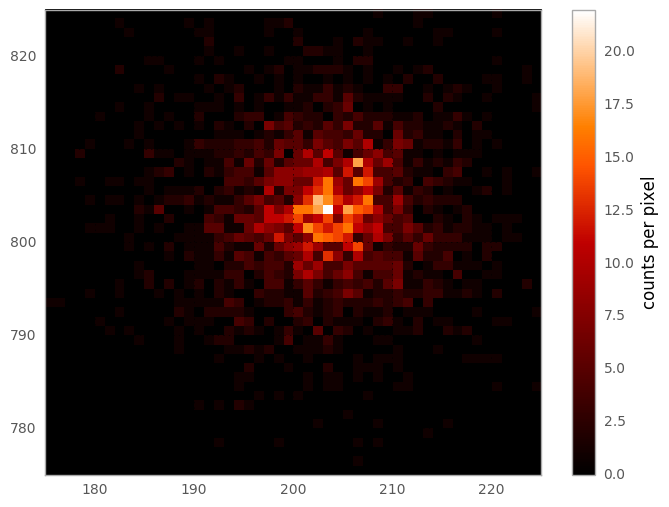

In [25]:
with plt.style.context(astropy_mpl_style):
    out = plt.hist2d(photdraw['detpix_x'][ind], photdraw['detpix_y'][ind], range=[[175, 225], [775, 825]], bins=50)
    cbar = plt.colorbar()
    cbar.set_label('counts per pixel')
    fig.savefig(figureout + 'CCD0_hist.pdf')

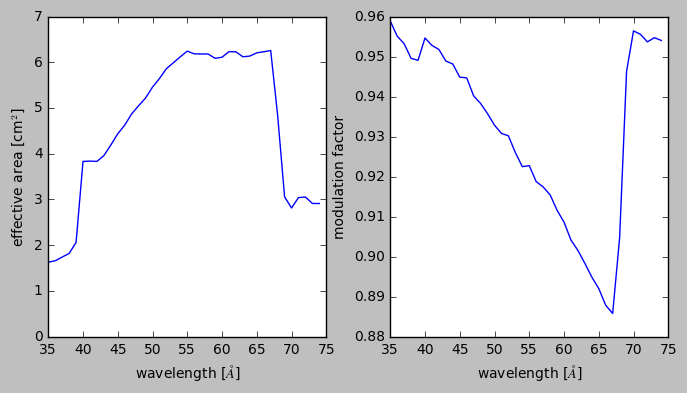

In [44]:
point_fixed = Table.read(os.path.join(datadir, 'aeff', 'deep.fits'))
with plt.style.context('default'):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    for i in [1]:
        ax1.plot(wave, point_fixed[0]['Aeff'][:, 1:].sum(axis=1) * Ageom, label='CCD {}'.format(i))
    # ax1.legend()
    ax1.set_xlabel('wavelength [$\AA$]')
    ax1.set_ylabel('effective area [cm$^2$]')
    ax1.set_xlim([35, 75])
    
    ax2 = fig.add_subplot(122)
    ax2.plot(wave, -point_fixed[0]['modulation'][:, 1])
    ax2.set_xlabel('wavelength [$\AA$]')
    ax2.set_ylabel('modulation factor')
    ax2.set_xlim([35, 75])
    
    fig.subplots_adjust(wspace=0.23)
    fig.savefig(figureout + 'aeff.pdf')

# SPIE proceeding

In [46]:
spiefig = '/melkor/d1/guenther/Dropbox/my_poster/17_SPIE_REDSoX/'

\begin{abstract}
X-ray Polarimetry offers a new window into the high-energy universe, yet there has been no instrument so far that could measure the polarization of soft X-rays from astrophysical sources (about 17-80 Angstroem).
The Rocket Experiment Demonstration of a Soft X-ray Polarimeter (REDSoX Polarimeter) is a proposed sounding rocket experiment that uses a focusing optic and splits the beam in three channels. Each channel has a set of critical-angle transmission (CAT) gratings that disperse the signal onto a laterally graded multilayer mirror (LGML), which preferentially reflects photons with a specific polarization angle. The three channels are oriented at 120 deg to each other and thus measure the three Stokes parameters: I, Q, and U.
The period of the LGML changes with position. The main design challenge is to arrange the gratings so that they disperse the spectrum in such a way that all rays are dispersed onto the position on the multi-layer mirror where they satisfy the local Bragg condition despite arriving on the mirror at different angles due to the converging beam from the focussing optics.
We present a polarimeteric Monte-Carlo ray-trace of this design to assess non-ideal effects from the e.g. mirror scattering or the finite size of the grating facets, and to compute engineering tolerances for each component. With mirror properties both simulated and measured in the lab for LGML mirrors of 80-200 layers we show that the reflectivity and the width of the Bragg-peak are sufficient to make this design work when non-ideal effects are included in the simulation.

\end{abstract}

\keywords{ray-tracing, X-ray optics, critical angle transmission grating, REDSoX polarimeter, multi-layer mirror, polarimetry}

### INTRODUCTION
\label{sect:introduction}

X-ray observations offer a unique way to study high-energy phenomena in the universe and there is a surprising number of science questions that require or at least benefit strongly from X-ray obserations. This includes such diverse objects as stars, interstellar gas, accreting neutron stars and low-mass black holes, and active galaxies powered by supermassive black holes. In the last few dacades our observational capabilities in the X-ray band have been ever expanding with more collecting area, and better temporal and spectral resolution over a wide band-pass. The last unexplored frontier is X-ray polarimetry, where little work has been done and essentially nothing is known below about 1~keV photon energy. Yet, X-ray polarimitry offers a new window to look at the most extreme sources. We expect X-rays to be polarized if they are generated in an environment with a preferred direction, such a the very strong magnetic field in magnetars or in relativistic jets. This background is discussed in more detail in a companion paper by Marshal et al.\ in the same volume \textbf{reference here}.

Here, we describe an instrument that can be used to measure the polarization in the soft X-ray band. In Sect.~\ref{sect:layout} we give an overview of the operating principle. In Sect.~\ref{sect:gratings} we derive the positioning of the gratings in the instrument analytically and we present ray-traces of this design in Sect.~\ref{sect:ray-trace} to include non-ideal effects such as the finite size of grating facets or uncertainties in the pointing direction into the derivation of effective area and figure of merrit. We discuss the limiting factors of the design in Sect.~\ref{sect:discussion} and end with a shot summary in Sect.~\ref{sect:summary}.

### LAYOUT OF REDSOX
\label{sect:layout}
The REDSoX polarimeter is designed to be lauched on a sounding rocket which delivers about 5~min of observing time per flight. One astronomical target will be observed per flight. The REDSoX polarimeter has a nested Wolter I type telescope consisting of nine thin shells made from Nickel. In the soft-X-ray regime, Ni has a good reflectivity and no coating is neccessary. Wolter I type telescopes are imaging optics and we expect the half-power diameter of the image in the focal plane to be about half an arcminute due to scattering from surface roughness and particulates. The surface roughness causes scattering in the plane of reflection, while particulate can scatter in any direction. As a result, the total scatter of incoming X-rays is larger in the plane and perpendicular to the plane of reflection. Detailed measurements are not available for the optics planned for the REDSoX polarimeter, so for the simulations we present below we assume that the distribution of scattering angles is Gaussian with a half-power diameter of 30~arcsec in the plane and one third of that (10~arcsec) out of the plane of reflection.

After passing through the mirror, photons encounter a set of critical angle transmission (CAT) gratings \cite{Heilmann:11}. These gratings are used at a blaze angle just below a degree where most of the diffracted photons are found in the first order. The zeroth order photons from all gratings are imaged onto a detector in the focal plane. This image is used to center the target correctly in flight, to monitor any drifts in the pointing and aspect control, to check for time-variability of the source on short time-scale, and to obtain a well-exposed spectrum at CCD resolution.

The gratings are grouped into three channels, where each channel has a different dispersion direction. For gratings in each channel, the first order photons are directed towards a laterally graded multilayer (LGML) mirror in such a way that each photon hits the mirror at the location where the local thickness of the layers gives the best Bragg condition for reflection. In Sect.~\ref{sect:gratings} we derive a formula to position the gratings such that this condition is fullfilles for all energies.

The REDSoX polarimeter is sensitive to polarization because the LGML mirrors are tilted by 45$^{\circ}$ with respect to the photon path. Photons with a polarization direction \textit{s} (perpendicular, from German: senkrecht) to the mirror will be reflected with a much higher probability than photons that are \textit{p} polarized (parallel to the mirror surface). A CCD detector catches the signal from each of the three LGML mirrors. The three mirrors are placed with a position angle of 120$^{\circ}$ relative to each other, so comparing the signal detected in all three detectors reveals the average polarization direction of the source in the sky.

Figure~\ref{fig:overview} shows a schematic overview of the design. See Marshall et al.\ in the same volume for more details on the REDSoX polarimeter design.

## POSITIONING THE GRATINGS
\label{sect:gratings}

In this section, we calculate how to position the gratings, such that the first order dispersed light hits the LGML mirror exactly where it fullfills the local Bragg condition. We use a cartesian coordinate system (x, y, z)\footnote{We use column vectors for coordiantes in our formulas, but take the liberty to simplify the notation and write them as row vectors when coordinates are given in the text.}, where the x-axis is the optical axis and an astrophysical target is located at $z=+\infty$. Photons pass through the mirror system first, where they are focussed towards the origin of the coordiantes system. We choose the $+x$ axis of the coordinate system as dispersion direction. The $+x$ axis runs along the active surface of the LGML mirror, whose unit normal pointing towards the refective surface is
\begin{equation}
\vec{n_m} = -\frac{1}{\sqrt{2}}\begin{pmatrix}0\\1\\1\end{pmatrix}.
\end{equation}
The grating "constant" for the LGML mirror depends on the $x$ coordinate (that is why it is called "laterally graded"):
\begin{equation}
D(x) = G_0 + x G
\label{eqn:Dx}
\end{equation}
where $G_0$ is the grating constant at $x=0$ and $G$ is slope of the grating constant. Our design uses $G = 0.88$~\AA{}~mm$^{-1}$. The Bragg condition at position $x$ then requires the following relation between wavelength $\lambda$ and unit vector $\vec{p}$ in ray direction:
\begin{equation}
n \lambda = 2 D(x) |\vec{p} \cdot (\vec{n_m}|\;. \label{eqn:Bragg}
\end{equation}
We set up the system to work with the first order Bragg peak $n=1$.

### Grating on the optical axis

We first look at the simple case of a grating that is located on the optical axis at the coordiantes (0, 0, $z_g$). Such a grating with grating constant $d_g$ has the grating equation
\begin{equation}
\sin\alpha = m \frac{\lambda}{d_g}\;. \label{eqn:gratingeqn}
\end{equation}
We will desing the instrument to work with photons in diffraction order $m=1$. The propogation direction of first order photons leaving the grating is then 
\begin{equation}
\vec{p} = \begin{pmatrix}\sin\alpha\\0\\-\cos\alpha\end{pmatrix}\label{eqn:ponaxis}
\label{eqn:ponaxis}
\end{equation}
Photons are going to hit the LGML mirror at
\begin{equation}
x = z_g \tan(\alpha) \;.
\end{equation}
Combining the previous three equations with the Bragg condition \ref{eqn:Bragg} and using a small angle approximation for $\alpha$ with $\cos\alpha\approx1$ and $\tan\alpha\approx\sin\alpha$ we can solve for the best grating position $z_g$:
\begin{equation}
z_g = \frac{d_g}{\sqrt{2} G} - \frac{d_g G_0}{G \lambda} \;.
\end{equation}
From this we can see that we can only find a $z_g$ that works for all wavelength $\lambda$ if $G_0 =0$. We will thus set $G_0=0$ in eqn.~\ref{eqn:Dx} for now and and simplify the equation in the next section where we calculate the grating positions in the more general case for gratings that do not have $x_g=0$ and $y_g=0$.

### Grating position in general

It is convenient to introduce a spherical coordinate system, because the optical focusses all photons onto the origin. We now look at a grating located at
\begin{equation}
\vec{r_g} = r_g\begin{pmatrix}\sin\gamma_g\\\cos\gamma_g\sin\beta_g\\\cos\gamma_g\cos\beta_g\end{pmatrix}
\label{eqn:rg}
\end{equation}
where $r_g$ is simply the distance between the grating and the focal point, $\gamma_g$ is the angle between axis along which the LGML is graded (which is the x-axis) and the line connecting the center of the grating and the focal point, and $\beta_g$ is the angle between that line and the $y=0$ plane. A photon hitting this grating will have the direction vector $\vec{p} = -(\sin\gamma_g, \cos\gamma_g\sin\beta_g, \cos\gamma_g\cos\beta_g)$. We need to place the gratings so that they are essentially perpendicular to the beam (see discussion on the blaze angle below) to reduce the shadows cast by the level 1 and 2 support structures of the gratings. We also want to orient the gratings such that they disperse along the x-axis. This means that we can write the diffraction of photons as a rotation with angle $\alpha$ from eqn.~\ref{eqn:gratingeqn} around the axis:
\textbf{check minus sign from here on!}
\begin{equation}
\vec{a} = \vec{p} \times \begin{pmatrix}1\\0\\0\end{pmatrix}=\begin{pmatrix}0\\\cos\gamma_g\cos\beta_g\\-\cos\gamma_g\sin\beta_g\end{pmatrix}
\end{equation}
We can write the rotation matrix around this axis as 
\begin{equation}
\mathsf{R}= \cos\alpha \mathsf{E} + \sin\alpha \begin{pmatrix}0&\cos\gamma_g\sin\beta_g&\cos\gamma_g\cos\beta_g\\-\cos\gamma_g\sin\beta_g&0&0\\-\cos\gamma_g\cos\beta_g&0&0\end{pmatrix} + (1-\cos\alpha)\begin{pmatrix}0&0&0\\0&\dots&\dots\\0&\dots&\dots\end{pmatrix}
\end{equation}
where $\mathsf{E}$ is the identity matrix and we use a small angle approximation for $\cos(\alpha_g)\approx1$.
So, the new direction vector $\vec{p_1}$ of a dispersed first order photon is
\begin{equation}
\vec{p_1} = \mathsf{R} \vec{p} = -\begin{pmatrix}\sin\gamma_g\\\cos\gamma_g\sin\beta_g\\\cos\gamma_g\cos\beta_g\end{pmatrix} - \frac{\lambda}{d_g}\begin{pmatrix}\cos^2\gamma_g\\-\sin\gamma_g\cos\gamma_g\sin\beta_g\\-\sin\gamma_g\cos\gamma_g\cos\beta_g\end{pmatrix}
\end{equation}
where we have used eqn.\ref{eqn:gratingeqn}.

We can now plug this photon direction vector into the Bragg condition \ref{eqn:Bragg}, where we replace $D(x)$ with eqn.~\ref{eqn:Dx} with $G_0 = 0$ and find
\begin{equation}
\lambda = \sqrt{2} G x \cos\gamma_g(\sin\beta_g + \cos\beta_g)(1 - \frac{\lambda}{d_g} \sin\gamma_g)
\label{eqn:lambda}
\end{equation} 
where the last term can be dropped because the wavelength $\lambda$ is always much smaller than the grating constant $d_g$.

We now need to express the position $x$ in terms of the grating coordiantes and the photon wavelength $\lambda$. The equation for a diffracted ray is:
\begin{equation}
\vec{r} = \vec{r_g} + c \vec{p_1} \;.
\label{eqn:vecr}
\end{equation}
It is sufficient to just write out the z component of this equation to see where the ray intersects the mirror, which will happen when the ray passes the plane $z=0$. Solving for the parameter $c$ we get
\begin{equation}
c = \frac{r_g d_g}{d_g - \lambda \sin\gamma_g} \approx r_g
\end{equation}
and now and plug this into the x component of eqn.~\ref{eqn:vecr} to find
\begin{equation}
x = \frac{r_g}{d_g}\lambda \cos^2\gamma_g\;.
\end{equation}
This finally allows us a to calculate $r_g$ for a grating for any given $\gamma_g, \beta_g$ by inserting eqn.~\ref{eqn:x} into eqn.~\ref{eqn:lambda}:
\begin{equation}
r_g = \frac{d_g}{\sqrt{2}G \cos^3\gamma_g (\sin\beta_g + \cos\beta_g)}
\label{eqn:rg}
\end{equation}


### Filling the space available with gratings

Equation~\ref{eqn:rg} specifies the distance from the origin for a given $(\gamma_g, \beta_g)$ where a grting must be positioned to direct photons in the first diffraction order to the multi-layer mirror such that the local Bragg condition is fullfilled. In practice, however, gratings have a finite size and are manufactured from flat silicon wavers typical in a rectangular shape \textbf{Ralf citation here}. Also, gratings have to face the incoming photons. If the grating normal is not approximately parallel to the incoming photons, the support structures that are etched from the waver and that hold the active grating bars cast shadows and reduce the effective area of the instrument significantly. At the same time, the whole grating facets (bars, support structure and 0.5~mm frame around it) need to be positioned in space. For all those reasons, the gratings cannot follow the shape of the surface given by  exactly and there is an interplay between engeneering the grating mounting and optimizing the optical properties.

We place gratings in a rectangular grid to to fill the annulus under the mirror shells that is traversed by the photons after focussing. We apply eqn.~\ref{eqn:rg} to the center of the grating and use ray-tracing to calculate the non-ideal effects arsing from the finite size of flat gratings.

### Multiple channels

As described in Sect.~\ref{sect:layout}, the REDSoX polarimeter consists of three channels that measure different polarization directions simultaneously. To achieve this, the rectangular grid of gratings does not cover the full annulus, but only two opposing sectors, each of which is $60^{\circ}$ wide. This pair of sectors images onto one of the LGML mirrors. We call it a "channel" from now on. As can be seen in fig.~\ref{fig:gratings}, one of the two segments in each channel is "high" (larger $r_g$, because $\beta > 0$, see eqn.~\ref{eqn:rg}), the other one "low" (smaller $r_g$ because $\beta < 0$.

There are three channels. For channel 2 and 3 all gratings, the LGML mirror, and the CCD detector are rotated by $120^{\circ}$ and $-120^{\circ}$, respectively, around the optical axis with respect to channel 1 (fig.~\ref{fig:gratings}).

### Blaze angle

The grating placement as discussed above is for transmission gratings where both positive and negative diffraction orders receive a similar number of photons. Since each channel has only one LGML mirror, which only catches photons dirracted into the first positive order, this setup would not be very efficient. The REDSoX polarimeter uses CAT gratings where the diffraction efficiency is heavily skewed towards one side by blazing (tilting) the grating surface, see \citenum{2008SPIE.7011E..06H} for a detailed explanation. We rotate every grating facet by $0.8^{\circ}$ around the grating bar direction. This tilt is included in Fig.~\ref{fig:gratings}, but cannot be seen on scale of the image.

## RAY-TRACING
\label{sect:ray-trace}

We perform Monte-Carlo ray-trace calculations to validate the approximations in the derivation of eqn.~\ref{eqn:rg} and to assess non-ideal effects resulting from the finite size of the flat grating facets, which causes the position of the gratings to deviate from the ideal analytical surface. The ray-trace is done in Python with the MARXS package \cite{2016SPIE.9905E..56G} version \textbf{version here}. All of the specific REDSoX polarimeter code is available here \textbf{link to code and doi}. 

A detailed treatment of the mirror is not required for this simulation. We use an analytical prescription for a mirror that focusses all incoming rays perfectly into the focal point. We add a random scatter to the ray direction where the scattering angle is drawn from a Gaussian distribution with a half-power diameter (HPD) of 30~arcsec for in-plane scatter and one third of this, 10~arcsec, for out-of-plane scatter. The REDSoX polarimeter mirror shells follow a Wolter-Type I geometry, so this is reasonable approximation for on-axis sources, but it does not allow us to make predictions for the shape of off-axis sources.
Photons are placed on a ring-shaped aperture where the outer radius matches the outer radius of the largest shell and the inner radius matches the inner radius of the smallest shell. The real mirror shells have a finite thickness and thus the real geometric opening area is smaller than the ring used in the simulation. We scale all results to the correct geometric opening area. 

MARXS uses probability tracking for photons, meaning that a number between 1 and 0 is attached to every photon that indicates the probability that the photon is absobed by some element. This technique dramatically reduces the number of photons that needs to be simulated compared to a Monte-Carlo code that randomly discards photons according to the absorption probability at each optical element. For the mirrors we implement double reflection on a Ni surfcae at small angles with a refelction probability retrieved from \citenum{CXRO} and a 12\% obscuration from the support spider.

The CAT gratings are flat with a surface area of $8 \times 10$~mm$^2$ and a 0.5~mm wide frame around them. Diffraction efficiencies are calcualted with the commercial GSolver program and scaled to the efficiencies measured in beamline experiements for discrete energies \textbf{Ralf: What's the most appropriate refernec here?}. Our diffraction efficiency includes the shadowing by the level 1 and 2 support structures which is part of each grating facet, and the engeneering study (see \textbf{ref here} in this volume) indicates that the gratings can be mounted without additional obscuration.

The LGML mirrors are again flat surfaces. Mirrors with two different coatings (Cr/Sc) and (C/CrCo) are combined because each combination of elements is most efficient in a different bandpass. Reflectivities for the Cr/Sc mirrors are taken from the manufacturers (Rigaku) specifications and samples of C/CrCo mirrors have been measured in the lab for unpolarized X-rays. The width and amplitude of the Bragg-peak are taken from those lab measurements. In the REDSoX polarimeter design, photons arrive on the LGML mirrors over a range of angles (Fig.~\ref{fig:LGML}). The reflectivity for s and p-polarized photons changes with the angle. This change is interpolated from curves derived from \citenum{CXRO}.

Lastly, photons are detected on four CCD detectors which provide some intrisic energy resolution. The pixel size on each detector is $16\;\mu$m. CCD~0 lies in the focal plane and images the zeroths order photons to help the target aquisition, and to obtain a well-exposed spectrum to charactarize the state of the astronomical target during flight since many potential targets are time-variable. Due to space contraintes in the focal plane, CCD~0 is smaller than the other detectors with only $408 \times 1608$ pixels. CCDs~1-3 image the photons reflected from the LGML mirros in channels 1 to 3. They have $1632 \times 1608$ pixels and are rotated to maximize band caverage by placing the signal on the diagonal of the detector instead of a linear side.

We can now use the ray-traces to analyze the system performance. As a starting point, we run the ray-trace with a spectrum for the active galactic nucleus Mk 421. The spectrum is taken from \textbf{reference here} and we assume a polarization fraction of 20\%. We simulate a 300~s exposure, matching the typical flight time of a sounding rocket above the atmosphere. At the position angle used for this simulation, we find about equal number of photons in CCD 2 and 3 and a significantly lower number of photons in CCD~1 (Fig.~\ref{fig:obsspectrum}).  For real astrophysical source, the polarization fraction and angle can be calculated from the the comparison of the signal in the three channels.

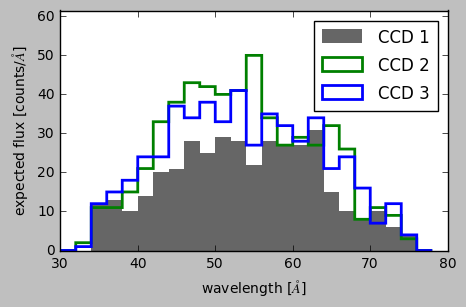

In [83]:
with plt.style.context('default'):
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    outmax = 0
    
    ind = (phot['CCD_ID'] == 3)
    out = ax.hist(phot['wave'][ind], #histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 1', lw=0, fc='0.4')#, fc='y')
    ind = (phot['CCD_ID'] == 1)
    out = ax.hist(phot['wave'][ind], histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 2', lw=2, ec='g')
    ind = (phot['CCD_ID'] == 2)
    out = ax.hist(phot['wave'][ind], histtype='step', #weights=phot['probability'][ind], 
                      bins=np.arange(30, 80, 2), label='CCD 3', lw=2, ec='b')
    outmax = np.max([outmax, np.max(out[0])])

    ax.set_ylim(0, outmax*1.5)
    ax.legend(loc='upper right')
    ax.set_xlabel('wavelength [$\AA$]')
    ax.set_ylabel('expected flux [counts/$\AA$]')
    fig.savefig(spiefig + 'obsspec.pdf')

Ray-trace simulations can also predict the total effective area and the minimum-detected polarization (MDP) of the REDSoX polarimeter. Figure~\ref{fig:aeff} shows the effective area $A_{\mathrm{eff}}$, the modulation factor ans the figure of merrit for the baseline REDSoX polarimeter design. The effective area (left panel) drops significantly below 40~\AA{} and above 70~\AA{}. Figure~\ref{fig:LGML} shows that photons from the high and the low sector in each channel are refelcted at different places on the LGML mirror and are thus seen in two distinct strips on the CCD. The physical dimension of the CCD is not big enough to capture all photons that are reflected from the LGML mirror. At wavelength below 40~\AA{} the photons from one sector drop of the CCD, at wavelength above 70~\AA{} the photons from the other sector. The bandpass covered is a design parameter. The CCDs could be moved a little to the left or to the right on the mount to shift the bandpass that the polarimater is sensitive to. Between those boundaries, the effective area increases for longer wavelengths because the reflectivity of the LGML mirrors increases with wavelength.

The modulation factor $M$ measures how much the amplitude of the detected signal changes with polarization angle. It is 1 if the detected signal vanishes completely for one polarization direction and 0 for an instrument that is not sensitive to polarization. The LGML mirrors essentially reflect only one polarization direction if the angle between ray and mirror normal is $45^\circ$, but for different angles, the reflectivity for p-polarized photons is non-negligable, which reduces the modulation factor. The two sectors in each channel "low" and "high" do not have the exact same signature. For most wavelength, $M$ contains contributions from both sectors but for $\lambda > 70$~\AA{} when half the signal drops of the detector, $M$ rises again.

The figure of merrit $F_m$ is defined as
\begin{equation}
F_m = M \sqrt{A_\textrm{eff}}
\end{equation}
and is discussed in more detail in the contribution \textbf{reference ot Marshall et al in this volume}.

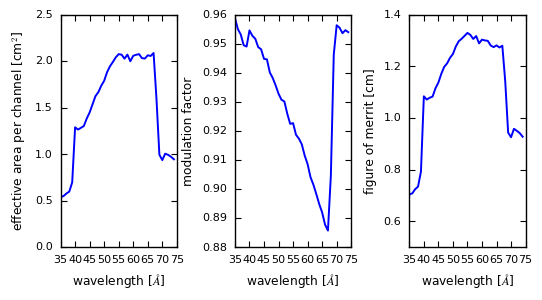

In [74]:
point_fixed = Table.read(os.path.join(datadir, 'aeff', 'deep.fits'))
with plt.style.context('seaborn-paper'):
    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_subplot(131)
    for i in [1]:
        ax1.plot(wave, point_fixed[0]['Aeff'][:, i] * Ageom, label='CCD {}'.format(i))
    # ax1.legend()
    ax1.set_xlabel('wavelength [$\AA$]')
    ax1.set_ylabel('effective area per channel [cm$^2$]')
    ax1.set_xlim([35, 75])
    
    ax2 = fig.add_subplot(132)
    ax2.plot(wave, -point_fixed[0]['modulation'][:, 1])
    ax2.set_xlabel('wavelength [$\AA$]')
    ax2.set_ylabel('modulation factor')
    ax2.set_xlim([35, 75])
    
    ax3 = fig.add_subplot(133)
    ax3.plot(wave, -point_fixed[0]['modulation'][:, 1] * np.sqrt(point_fixed[0]['Aeff'][:, i] * Ageom))
    ax3.set_xlabel('wavelength [$\AA$]')
    ax3.set_ylabel('figure of merrit [cm]')
    ax3.set_xlim([35, 75])
    fig.subplots_adjust(wspace=0.5)
    fig.savefig(spiefig + 'aeff.pdf')

In the next few sections, we present some ray-trace simulations where parameters are changed compared to the baseline case outlined above to analyze how different parameters impact the performance of the REDSoX polarimeter.

### Blaze angle

### Pointing jitter

We simulate pointing jitter be applying a random mispointing for any incoming ray. The position angle of this displacement is uniformly distributed, the separation to the nominal pointing is drawn from a Gaussian distribution. Misspointing reduces the effective area of the system, because photons that arrive at an angle with respect to the optical axis will not be focussed to the correct position on the LGML mirrors. The Bragg peak has a finite width, so some of them may still be reflected, but the number of reflected photons is reduced. Figure~\ref{fig:jitter} shows that the modulation does not change, but the effective area drops significantly, when the jitter becomes larger than the mirror scatter, which otherwise is the dominant process that causes photons to hit the LGML mirror away from the Bragg peak.

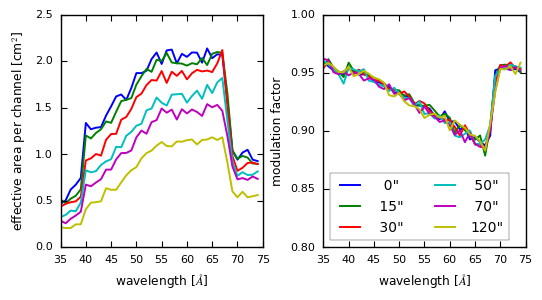

In [76]:
point_jitter = Table.read(os.path.join(datadir, 'aeff', 'pointing_jitter.fits'))

fig = plt.figure(figsize=(6, 3))

with plt.style.context('seaborn-paper'):
    ax = fig.add_subplot(1, 2, 1)
    axm = fig.add_subplot(122)
    for i in [0, 3, 4, 5, 6, 7]:  # Hand select which simulations to show to avoid crowding of lines
        ax.plot(wave, point_jitter[i]['Aeff'][:, 1] * Ageom, label='{0:3.0f}"'.format(point_jitter['jitter'][i]))
        axm.plot(wave, -point_jitter[i]['modulation'][:, 1], label='{0:3.0f}"'.format(point_jitter['jitter'][i]))

    axm.set_ylim([0.8, 1.0])
    axm.legend(ncol=2, loc='lower left', fontsize='medium')
    ax.set_xlabel('wavelength [$\AA$]')
    ax.set_ylabel('effective area per channel [cm$^2$]')
    ax.set_xlim([35, 75])
    
    axm.set_xlabel('wavelength [$\AA$]')
    axm.set_ylabel('modulation factor')
    axm.set_xlim([35, 75])
    fig.subplots_adjust(wspace=0.3)
    fig.savefig(spiefig + 'jitter.pdf')

### Mirror quality

### Subaperturing

Should this even be it's own section just so that I cna put in Hermann's zeroth order figure here? I don't think that that figure is critical here, so maybe I don't need it. On the other hand, it might help understanding.

## DISCUSSION OF LIMITATIONS

\label{sect:discussion}

bend gratings vs. segmented
change in focal length
Improvement in mirror scatter, higher peaks, better alignment and smaller gratings

## SUMMARY

\label{sect:summary}

\acknowledgments % equivalent to \section*{ACKNOWLEDGMENTS}       
\textbf{ADD REDSOX grant here} 
Support for this work was provided by NASA through the Smithsonian
   Astrophysical Observatory (SAO) contract SV3-73016 to MIT for Support
   of the Chandra X-Ray Center (CXC) and Science Instruments. CXC is
   operated by SAO for and on behalf of NASA under contract NAS8-03060.


% References
\bibliography{../../my_articles/articles} 
\bibliographystyle{spiebib} % makes bibtex use spiebib.bst

\end{document} 